# TP 3 Machine Learning : Classification Image

## Import les librairies

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential

## Creation de la dataframe des  metriques des modeles

In [29]:
# Creation de la dataframe qui contiendra les métriques des modèles
columns = ['Model', 'Training Time', 'Prediction Time', 'Loss', 'Accuracy', 'F1 Score']
model_metrics_df = pd.DataFrame(columns=columns)

In [20]:
# Fonction qui permet de calculer le F1 Score
def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

## Preparation des donnees pour l'entrainement

### Telechargement des donnees

In [21]:
# lecture des données mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### separation des donnees en train et test et normalisation

In [22]:
# Normalisation des données et separation des données de test et de validation
X_train = np.expand_dims(X_train, axis=-1) / 255.0
X_test = np.expand_dims(X_test, axis=-1) / 255.0

# conversion des labels en one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Deep Learning

## CNN

### Creation du modele

In [23]:
# construction du modèle CNN
inputs = Input(shape=X_train.shape[1:])
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)
cnn_model = Model(inputs=inputs, outputs=outputs)

### Augmentation des donnees

In [24]:
# augmentation des données
augmenter = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest"
)

### Entrainement du modele

In [25]:
# compilation du modèle et entrainement du modèle CNN
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_train_time = time.time()
cnn_model.fit(augmenter.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=10)
training_time = time.time() - start_train_time

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3954 - accuracy: 0.8745 - val_loss: 0.0506 - val_accuracy: 0.9828
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1671 - accuracy: 0.9512 - val_loss: 0.0289 - val_accuracy: 0.9901
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1272 - accuracy: 0.9624 - val_loss: 0.0285 - val_accuracy: 0.9907
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1009 - accuracy: 0.9695 - val_loss: 0.0241 - val_accuracy: 0.9924
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0906 - accuracy: 0.9726 - val_loss: 0.0220 - val_accuracy: 0.9927
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0809 - accuracy: 0.9763 - val_loss: 0.0256 - val_accuracy: 0.9924
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0761 - accuracy: 0.9779 - val_loss: 0.0273 -

### Evaluation du modele

In [26]:
# Evaluation du modèle CNN sur les données de test
start_pred_time = time.time()
cnn_predictions = cnn_model.predict(X_test)
prediction_time = time.time() - start_pred_time
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_f1 = calculate_f1(y_test.argmax(axis=1), cnn_predictions.argmax(axis=1))


313/313 [==============================] - 1s 2ms/step


### Matrice de confusion

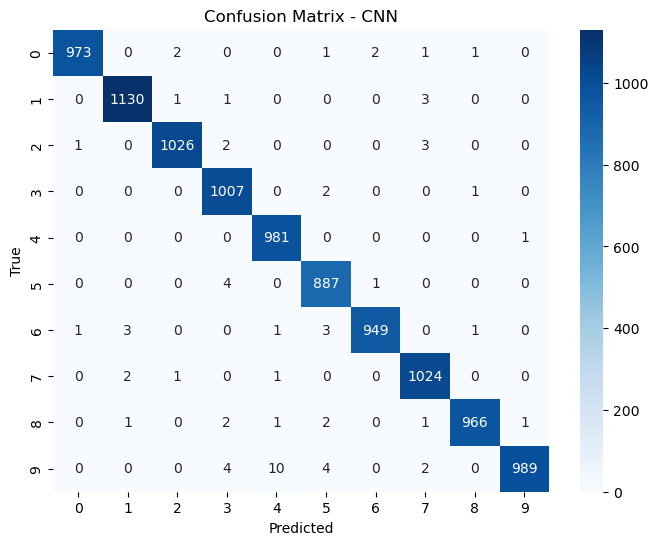

In [27]:
# diffusion des résultats du modèle CNN matrice de confusion
cm = confusion_matrix(y_test.argmax(axis=1), cnn_predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title(f'Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Sauvegarde des resultats du modele

In [30]:
# Ajout des résultats du modèle CNN dans la dataframe "model_metrics_df
model_metrics_df.loc[len(model_metrics_df)] = ['CNN', training_time, prediction_time, cnn_loss, cnn_accuracy, cnn_f1]

# Machine Learning

## Preparation des donnees pour l'entrainement

### Flattening and splitting

In [31]:
# " flatten " des données pour les modèles KNN, SVM et Naive Bayes
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))


## KNN  

### Creation du modele

In [32]:
# initialisation du modèle KNN
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
start_train_time = time.time()
knn.fit(X_train_flat, y_train.argmax(axis=1))
training_time = time.time() - start_train_time


### Evaluation du modele

In [33]:
# evaluation du modèle KNN sur les données de test
start_pred_time = time.time()
knn_predictions = knn.predict(X_test_flat)
prediction_time = time.time() - start_pred_time
knn_accuracy = accuracy_score(y_test.argmax(axis=1), knn_predictions)
knn_f1 = calculate_f1(y_test.argmax(axis=1), knn_predictions)

### Matrice de confusion

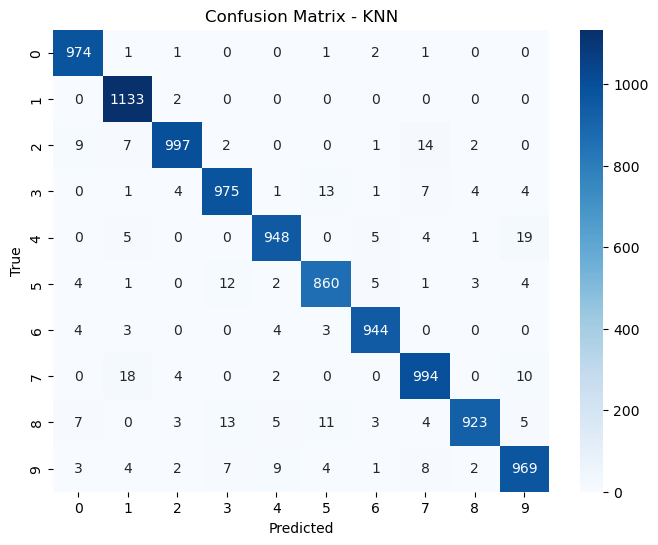

In [34]:
# diffusion des résultats du modèle KNN matrice de confusion
cm = confusion_matrix(y_test.argmax(axis=1), knn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title(f'Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Sauvegarde des resultats du modele

In [35]:
# Ajout des résultats du modèle KNN dans la dataframe "model_metrics_df
model_metrics_df.loc[len(model_metrics_df)] = ['KNN', training_time, prediction_time, knn_accuracy, knn_accuracy, knn_f1]

## SVM

### Creation du modele

In [36]:
# initialisation du modèle SVM
svm = SVC(kernel='linear', probability=True)
start_train_time = time.time()
svm.fit(X_train_flat, y_train.argmax(axis=1))
training_time = time.time() - start_train_time

### Evaluation du modele

In [37]:
# evaluation du modèle SVM sur les données de test
start_pred_time = time.time()
svm_predictions = svm.predict(X_test_flat)
prediction_time = time.time() - start_pred_time
svm_accuracy = accuracy_score(y_test.argmax(axis=1), svm_predictions)
svm_f1 = calculate_f1(y_test.argmax(axis=1), svm_predictions)

### Matrice de confusion

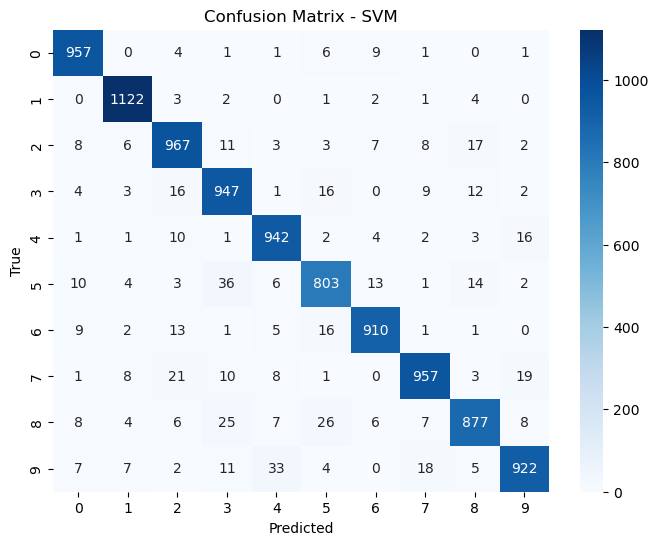

In [38]:
# Diffusion des résultats du modèle SVM matrice de confusion
cm = confusion_matrix(y_test.argmax(axis=1), svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title(f'Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Sauvegarde des resultats du modele

In [39]:
# Ajout des résultats du modèle SVM dans la dataframe "model_metrics_df
model_metrics_df.loc[len(model_metrics_df)] = ['SVM', training_time, prediction_time, svm_accuracy, svm_accuracy, svm_f1]

## Naive Bayes

### Creation du modele

In [40]:
# initialisation du modèle Naive Bayes
nb = MultinomialNB()
start_train_time = time.time()
nb.fit(X_train_flat, y_train.argmax(axis=1))
training_time = time.time() - start_train_time

### Evaluation du modele

In [41]:
# evaluation du modèle Naive Bayes sur les données de test
start_pred_time = time.time()
nb_predictions = nb.predict(X_test_flat)
prediction_time = time.time() - start_pred_time
nb_accuracy = accuracy_score(y_test.argmax(axis=1), nb_predictions)
nb_f1 = calculate_f1(y_test.argmax(axis=1), nb_predictions)

### Matrice de confusion

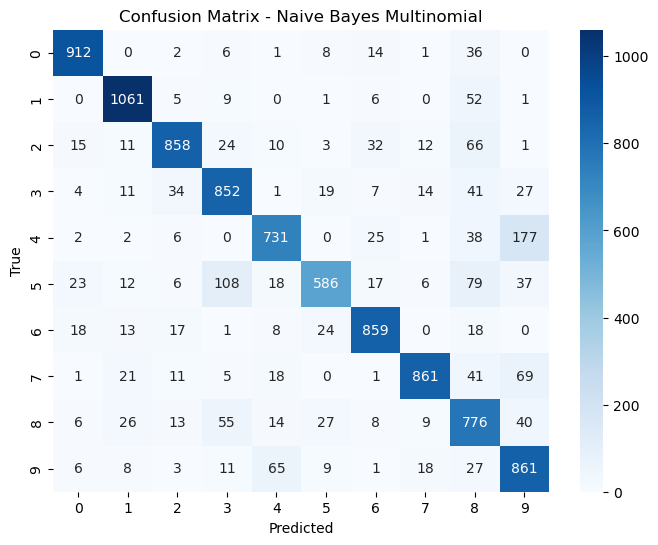

In [42]:
# Diffusion des résultats du modèle Naive Bayes matrice de confusion
cm = confusion_matrix(y_test.argmax(axis=1), nb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title(f'Confusion Matrix - Naive Bayes Multinomial')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Sauvegarde des resultats du modele

In [43]:
# Ajout des résultats du modèle Naive Bayes dans la dataframe "model_metrics_df
model_metrics_df.loc[len(model_metrics_df)] = ['Naive Bayes Multinomial', training_time, prediction_time, nb_accuracy, nb_accuracy, nb_f1]

# Enregistrement des modeles

In [58]:
# Sauvegarde des modèles CNN, KNN, SVM et Naive Bayes

#CNN
cnn_model.save('cnn_model.h5')

#KNN(joblib)
dump(knn, 'knn_model.joblib')

#SVM(joblib)
dump(svm, 'svm_model.joblib')

#Naive Bayes(joblib)
dump(nb, 'nb_model.joblib')


['nb_model.joblib']

# Difusion des resultats de l'analyse

## affichage des resultats dataframe

In [44]:
# affichage des résultats des modèles
model_metrics_df

,Model,Training Time,Prediction Time,Loss,Accuracy,F1 Score
0,CNN,191.662644,0.812425,0.022906,0.9932,0.993199
1,KNN,0.059491,5.308318,0.971700,0.9717,0.971663
2,SVM,1042.868368,36.827754,0.940400,0.9404,0.940281
3,Naive Bayes Multinomial,0.164751,0.015554,0.835700,0.8357,0.836453


## affichage des resultats graphiques

### precision

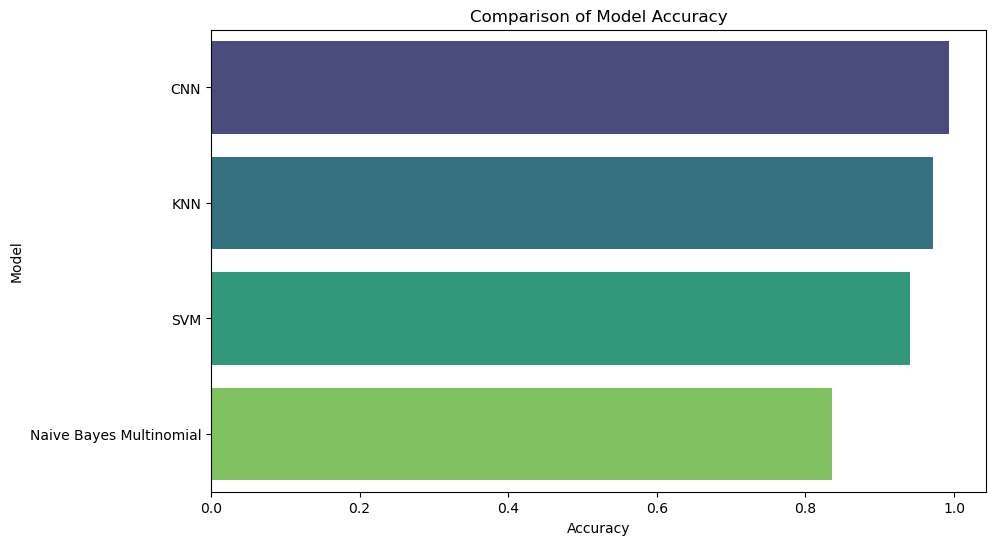

In [51]:
# Comparaison des modèles en fonction de leur précision
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=model_metrics_df.sort_values(by='Accuracy', ascending=False), palette='viridis')
plt.title('Comparison of Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

### F1 score

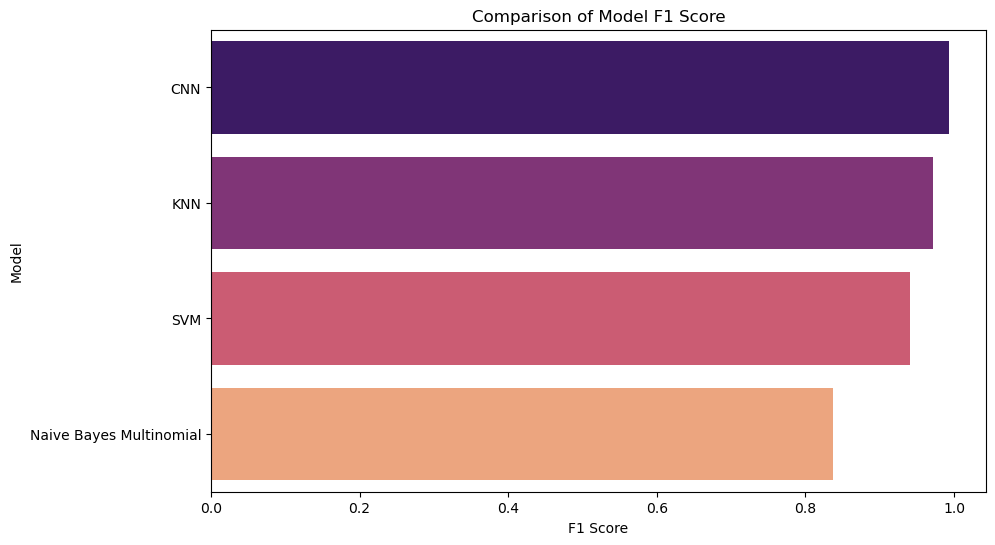

In [52]:
# Comparaison des modèles en fonction de leur F1 Score
plt.figure(figsize=(10, 6))
sns.barplot(x='F1 Score', y='Model', data=model_metrics_df.sort_values(by='F1 Score', ascending=False), palette='magma')
plt.title('Comparison of Model F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.show()

### Learning time

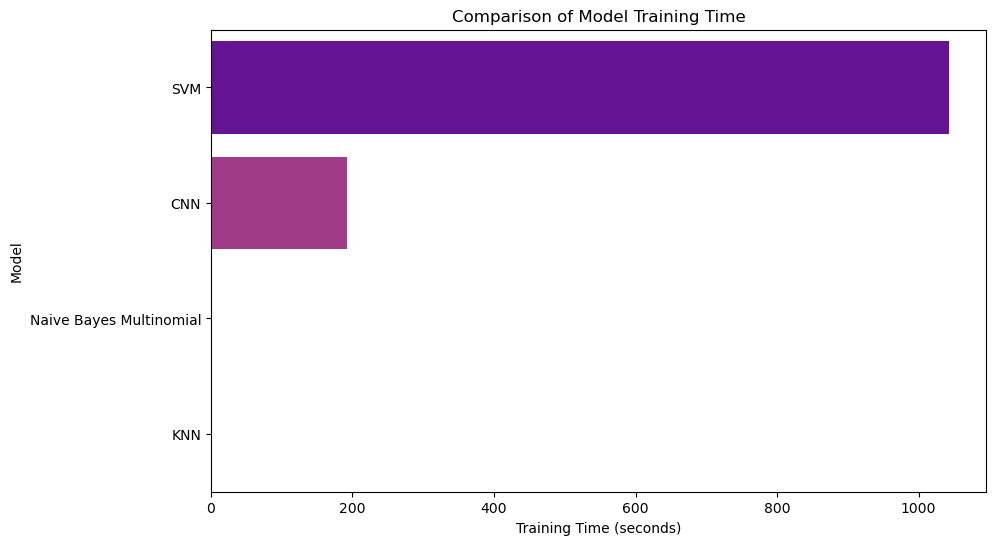

In [53]:
# Comparaison des modèles en fonction de leur temps d'enrtrainement
plt.figure(figsize=(10, 6))
sns.barplot(x='Training Time', y='Model', data=model_metrics_df.sort_values(by='Training Time', ascending=False), palette='plasma')
plt.title('Comparison of Model Training Time')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Model')
plt.show()

### Prediction time

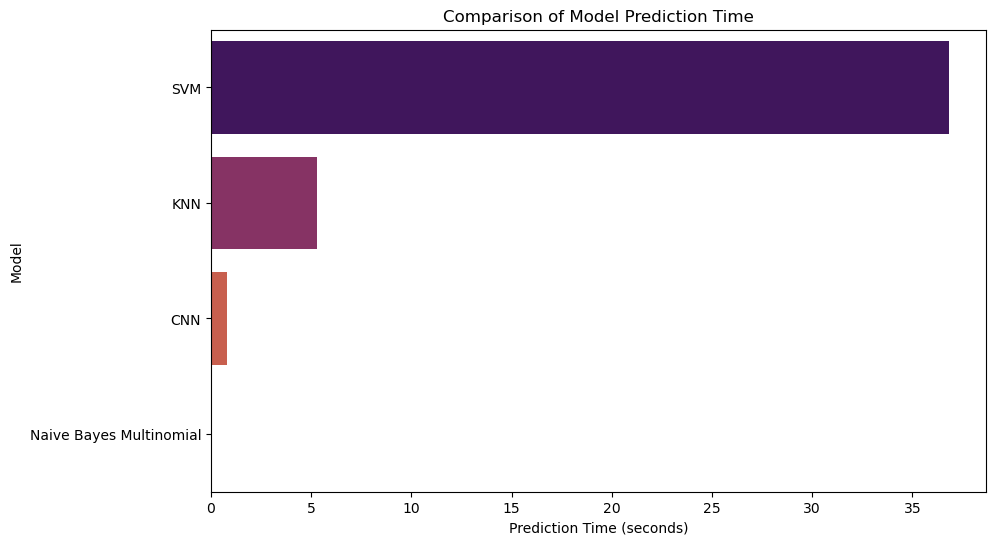

In [54]:
# Comparaison des modèles en fonction de leur temps de prédiction
plt.figure(figsize=(10, 6))
sns.barplot(x='Prediction Time', y='Model', data=model_metrics_df.sort_values(by='Prediction Time', ascending=False), palette='inferno')
plt.title('Comparison of Model Prediction Time')
plt.xlabel('Prediction Time (seconds)')
plt.ylabel('Model')
plt.show()